## Decision Tree: Branch Analyses

1. Reporting Year (Year 0 - baseline)
2. TTC Tree cover
3. Land Use
4. Strategy
5. Imagery or site accessibility


Imagery Availability:  
- Is there imagery available for reporting year 0 (baseline)? Within 1 yr of planting date, there are >=1 images available with <50% cloud cover
- Is there imagery available for reporting year 1-3 (early verification)? Within the first 1-3 years of planting date, there are >=1 images available with <50% cloud cover
- Is there imagery available for reporting year 5 (endline)? After 5 years after planting, there are >=1 images available with <50% cloud cover  

Shadow (sun elevation):  
- Of the images available, >= 1 image is not affected by shade? (this question would use the sun elevation metrics) for now, we could just separate this into a binary option - low sun elevation or high sun elevation

### Decisions
- An "open" or "closed" designation was assigned at the project level based on the proportion of sites that fell the into open/closed category.
- Project names that did not align were dropped.
- ttc NA - sites without TTC % were dropped. Missing TTC tiles, eventually will have data. 
- Sites where planting occurs in 2025 were dropped. Check the other sites.
- What does imagery % represent and what is a workable threshold? Does it represent coverage for the polygon or wider AOI?
- plant_start - date that planting is started is available by site, so would have to aggregate for a project. Does it make sense to do the first date of planting?
  
**Target Land Use**
- Both TTC and feats contain a target land use. Feats could take priority as it is cleaner and already agg to project level?
- TTC is CURRENT land use (used for error calcs)
- In feats spreadsheet, 25 projects do not have a target land use system.
- Can I assume that any LU that is not in 'direct_seeding', 'tree_planting', 'assisted_natural_regeneration', is a type of ANR?



In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from os import listdir

### Align datasets

In [61]:
ft_raw = pd.read_excel('project_feats_062024.xlsx')
ft_raw.head()

,Project,Area_ha,KRB_overlap_ha,percent_KRB_overlap,GRV_overlap_ha,percent_GRV_overlap,GhanaCocoaBelt_overlap_ha,percent_GhanaCocoaBelt_overlap,percent_any_landscape,ImageryCoverage_ha,...,enrichment planting,reforestation,direct propagules planting,natural regeneration,applied nucleation/tree island,woodlot,direct seeding,mangrove tree restoration,natural forest,riparian restoration
0,green-pot,54.528749,0.0,0.0,54.528749,100.000000,0.000000,0.000000,100.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.528749
1,inec-ghana,93.379960,0.0,0.0,0.000000,0.000000,93.379960,100.000000,100.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,dnrc,383.638568,0.0,0.0,383.638568,100.000000,0.000000,0.000000,100.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,hen-mpoano,75.897488,0.0,0.0,0.000000,0.000000,75.320688,99.240027,99.240027,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,sadhana-forest-kenya,98.556882,0.0,0.0,96.090085,97.497083,0.000000,0.000000,97.497083,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [62]:
print(len(ft_raw.Project.unique()))
print(len(ttc_raw.Project.unique()))

76
76


In [63]:
# s3d niger should be dropped - is inactive
ft_prj = sorted(ft_raw.Project.unique())
ttc_prj = sorted(ttc_raw.Project.unique())
no_match1 = [i for i in ft_prj if i not in ttc_prj]
no_match2 = [i for i in ttc_prj if i not in ft_prj]
no_match1, no_match2

(['acacia-epz', 'cerath', 'iita', 's3d-niger'],
 ['addax-gum', 'dedras-ong', 'herp-ghana', 'sahel-eco-mali'])

## clean TTC

In [64]:
ttc_raw = pd.read_excel('ttc_baseline_062024.xlsx')

# clean column names and datatypes, drop NaNs
to_keep = ['Percent Tree Cover 2020', 'Project', 'SiteName', 'areaHa', 'plantstart', 'target_sys']
drop_cols = [col for col in ttc_raw.columns if col not in to_keep]
ttc = ttc_raw[to_keep]
ttc.columns = ttc.columns.map(lambda x: re.sub(' ', '_', x.lower().strip()))
ttc = ttc.rename(columns={'percent_tree_cover_2020': 'ttc'})
ttc = ttc[ttc['ttc'] != 'TTC_NA'] #drops 221 rows
ttc['ttc'] = ttc['ttc'].astype('float')
ttc['ttc'] = ttc['ttc'].round()
ttc['plantstart'] = pd.to_datetime(ttc['plantstart'], errors='coerce')

print(ttc['ttc'].min(), ttc['ttc'].max())

def classify_canopy(project):
    closed_canopy = (project['ttc'] > 40).sum()
    open_canopy = (project['ttc'] <= 40).sum()
    return 'open' if open_canopy > closed_canopy else 'closed'

# Apply the classification function to each group
# .transform() method in pandas is used to apply a function to a group or subset of a df and 
# return an aligned result, meaning the output has the same shape as the input.
ttc['canopy'] = ttc.groupby('project')['ttc'].transform(lambda x: classify_canopy(ttc[ttc['project'] == x.name]))

ttc.info()

0.0 100.0
<class 'pandas.core.frame.DataFrame'>
Index: 11449 entries, 0 to 11448
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ttc         11449 non-null  float64       
 1   project     11449 non-null  object        
 2   sitename    11449 non-null  object        
 3   areaha      11449 non-null  float64       
 4   plantstart  11440 non-null  datetime64[ns]
 5   target_sys  11449 non-null  object        
 6   canopy      11449 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 715.6+ KB


In [96]:
list(set(ttc.project))

['safire',
 'mapto',
 'ileg',
 'shekina',
 'surudev',
 'ecotrust-uganda',
 'bccp',
 'ecocare-ghana',
 'apaf-togo',
 'ncf',
 'mt-kenya-env-cons',
 'soc-cons-nature-liberia',
 'ageref-cl',
 'kijani-forestry',
 'eco-benin',
 'kea',
 'panr',
 'solid-east-central-afr-zambia',
 'ope',
 'lead-foundation',
 'pado-investments',
 'inec-ghana',
 'sos-forets',
 'fairtree-tanzania',
 'ccao',
 'arcos',
 'centre-valbio',
 'sadhana-forest-kenya',
 'asic',
 'aradin',
 'adhd',
 'my-trees-trust',
 'addax-gum',
 'fote-ghana',
 'per-ja-t',
 'fairtree-kenya',
 'kenvo',
 'durrell',
 'blessed-action',
 'wildlife-action-group',
 'intl-tree-foundation',
 'aerobic-agroforestry',
 'world-vision-intl-ethiopia',
 'plant-with-purpose-burundi',
 'fap-ngo',
 'trees-for-the-future',
 'inst-oikos-onlus',
 'icraf',
 'afrex-gold',
 'blue-forest',
 'pades',
 'env-coffee-forest-forum',
 'sahel-eco-mali',
 'herp-ghana',
 'snrma',
 'kijabe-forest-trust',
 'wells-for-zoe',
 'dedras-ong',
 'justdiggit',
 'goshen-global-vision',

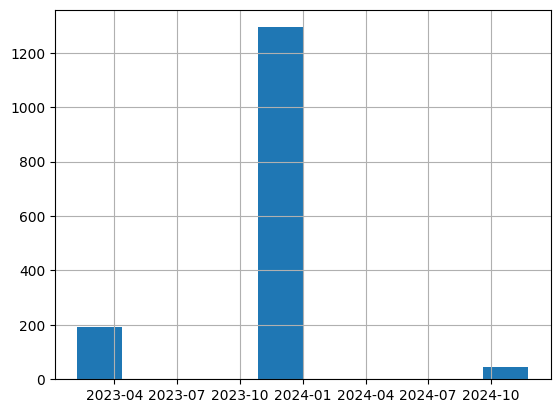

In [99]:
bccp = ttc[ttc.project == 'birdlife-intl']
bccp['plantstart'].hist();

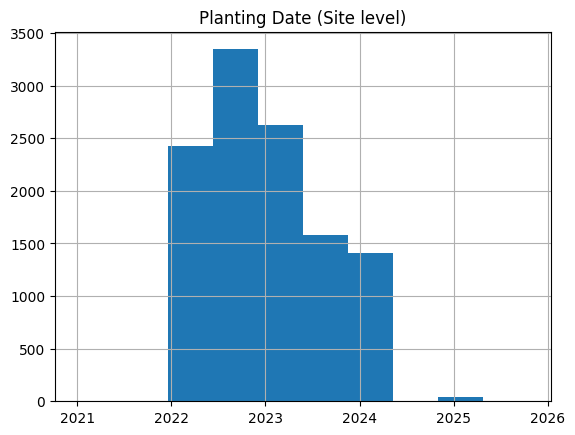

In [65]:
ttc['plantstart'].hist().set_title('Planting Date (Site level)');

In [66]:
ttc[ttc.plantstart == ttc['plantstart'].max()]

,ttc,project,sitename,areaha,plantstart,target_sys,canopy
3405,2.0,icraf,Kayonza,125.089622,2025-10-17,agroforest,open


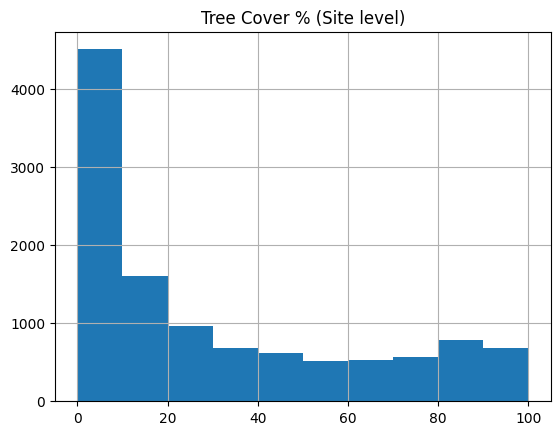

In [67]:
ttc['ttc'].hist().set_title('Tree Cover % (Site level)');

In [68]:
print(f"Total sites <=40% cover: {len(ttc[ttc.ttc <= 40])}")
print(f"Total sites >40% cover: {len(ttc[ttc.ttc > 40])}")

Total sites <=40% cover: 7808
Total sites >40% cover: 3641


In [69]:
ttc.canopy.value_counts()

canopy
open      8552
closed    2897
Name: count, dtype: int64

### Image Availability

In [76]:
ttc

,ttc,project,sitename,areaha,plantstart,target_sys,canopy
0,84.0,aerobic-agroforestry,AGO OWU,553.954186,2024-04-01,Null,closed
1,0.0,tree-adoption-uganda,AGU - Tree Adoption Uganda,1.124014,2022-09-01,agroforest,open
2,8.0,tree-adoption-uganda,AGU - Tree Adoption Uganda,1.265998,2022-09-01,agroforest,open
3,0.0,tree-adoption-uganda,AGU - Tree Adoption Uganda,0.892631,2022-09-01,agroforest,open
4,0.0,tree-adoption-uganda,AGU - Tree Adoption Uganda,0.905511,2022-09-01,agroforest,open
...,...,...,...,...,...,...,...
11444,7.0,bccp,Kikuube,0.085057,2023-04-01,agroforest,open
11445,75.0,dnrc,Maiuni - DNRC,0.320663,2022-11-01,agroforest,open
11446,1.0,bccp,Hoima,0.335454,2022-08-01,Null,open
11447,0.0,bccp,Hoima,0.467644,2023-04-01,Null,open


In [85]:
# create a master csv of all projects for img availability, elevation and sun
img_dir = 'imagery_availability/cohort1/'
csv_list = listdir(img_dir)
csv_list = [re.split(r'_', file)[1] for file in csv_list if file.endswith('.csv')]
master_csv = pd.DataFrame()
for i in csv_list[0:1]:
    i = 'bccp'
    df = pd.read_csv(f'{img_dir}afr100_{i}_imagery_availability.csv')
    df = df[['id', 
             'collection', 
             'properties.datetime',
             'properties.eo:cloud_cover',
             'properties.collect_time_end',
             'properties.collect_time_start',
#              'properties.off_nadir_avg', 
#              'properties.off_nadir_end',
#              'properties.off_nadir_max', 
#              'properties.off_nadir_min',
#              'properties.view:sun_elevation_max',
#              'properties.view:sun_elevation_min',
            ]]
    dt_cols = ['properties.datetime',
                 'properties.collect_time_end',
                 'properties.collect_time_start',
               ]
    df[dt_cols] = df[dt_cols].apply(pd.to_datetime, errors='coerce')
    # Ensure 'properties.datetime' column is timezone-naive
    df['properties.datetime'] = df['properties.datetime'].apply(lambda x: x.replace(tzinfo=None) if x.tzinfo else x)
    planting_date = ttc[ttc.project == i]['plantstart']
#    df['baseline_imgs'] = df['properties.datetime'].apply(lambda x: 1 if planting_date <= x <= planting_date + timedelta(days=365) else 0)
#     df['baseline_cloud_free'] = len(df[(df['baseline_imgs'] == 1) & (df['properties.eo:cloud_cover'] == 1)])
#     agg_data = {
#         'project_name': i,
#         'total_imgs': len(df),
#         'total_cloud_free': sum(df['properties.eo:cloud_cover']),
#         'baseline_imgs': sum(df['baseline_imgs']),
#         'baseline_cloud_free':sum(df['baseline_cloud_free']),
#                              }
# #         'early_imgs':,
# #         'early_cloud_free',
# #         'endline_imgs':,
# #         'endline_cloud_free':,
#     agg_table = pd.DataFrame([agg_data])
    

In [86]:
df

,id,collection,properties.datetime,properties.eo:cloud_cover,properties.collect_time_end,properties.collect_time_start
0,10300100FB237600,wv02,2024-06-04 08:24:30.817156,56.323246,2024-06-04 08:24:35.673101+00:00,2024-06-04 08:24:30.817156+00:00
1,10300100FB205400,wv02,2024-05-24 08:18:51.201466,97.810404,2024-05-24 08:18:55.801408+00:00,2024-05-24 08:18:51.201466+00:00
2,10300100F717C300,wv02,2024-04-04 08:34:11.434514,97.605252,2024-04-04 08:34:16.057659+00:00,2024-04-04 08:34:11.434514+00:00
3,10300100F9AE3900,wv02,2024-03-19 08:21:23.911870,50.903587,2024-03-19 08:21:37.307003+00:00,2024-03-19 08:21:23.911870+00:00
4,10300100E9BA7600,wv02,2023-06-20 08:38:05.759676,75.135552,2023-06-20 08:38:11.138819+00:00,2023-06-20 08:38:05.759676+00:00
...,...,...,...,...,...,...
1892,10300100EAD21A00,wv02,2023-07-12 08:30:51.791639,26.635664,2023-07-12 08:31:08.817965+00:00,2023-07-12 08:30:51.791639+00:00
1893,10300100E54A8C00,wv02,2023-04-05 08:24:25.427632,51.455326,2023-04-05 08:24:40.557963+00:00,2023-04-05 08:24:25.427632+00:00
1894,10300100CAB81900,wv02,2021-12-02 08:18:24.028713,12.972282,2021-12-02 08:18:40.857439+00:00,2021-12-02 08:18:24.028713+00:00
1895,10300100F76F1400,wv02,2024-03-03 08:08:56.988314,15.455987,2024-03-03 08:09:03.899455+00:00,2024-03-03 08:08:56.988314+00:00


In [90]:
ttc[ttc.project == 'bccp']

,ttc,project,sitename,areaha,plantstart,target_sys,canopy
2987,0.0,bccp,Hoima,0.675370,2022-08-01,agroforest,open
2988,3.0,bccp,Hoima,1.150452,2022-08-01,agroforest,open
2989,5.0,bccp,Hoima,0.568901,2022-08-01,agroforest,open
2990,0.0,bccp,Hoima,1.055517,2022-08-01,agroforest,open
2991,0.0,bccp,Hoima,0.687014,2022-08-01,agroforest,open
...,...,...,...,...,...,...,...
11404,64.0,bccp,Masindi,0.246053,2022-08-01,Null,open
11405,69.0,bccp,Masindi,0.470085,2022-08-01,Null,open
11444,7.0,bccp,Kikuube,0.085057,2023-04-01,agroforest,open
11446,1.0,bccp,Hoima,0.335454,2022-08-01,Null,open


In [89]:
planting_date = ttc[ttc.project == 'bccp']['plantstart']
planting_date

2987    2022-08-01
2988    2022-08-01
2989    2022-08-01
2990    2022-08-01
2991    2022-08-01
           ...    
11404   2022-08-01
11405   2022-08-01
11444   2023-04-01
11446   2022-08-01
11447   2023-04-01
Name: plantstart, Length: 418, dtype: datetime64[ns]

In [43]:
master_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   id                                 122 non-null    object             
 1   collection                         122 non-null    object             
 2   properties.datetime                122 non-null    datetime64[ns, UTC]
 3   properties.off_nadir_avg           122 non-null    float64            
 4   properties.off_nadir_end           122 non-null    float64            
 5   properties.off_nadir_max           122 non-null    float64            
 6   properties.off_nadir_min           122 non-null    float64            
 7   properties.eo:cloud_cover          122 non-null    float64            
 8   properties.collect_time_end        122 non-null    datetime64[ns, UTC]
 9   properties.collect_time_start      122 non-null    dat

In [44]:
master_table

,id,collection,properties.datetime,properties.off_nadir_avg,properties.off_nadir_end,properties.off_nadir_max,properties.off_nadir_min,properties.eo:cloud_cover,properties.collect_time_end,properties.collect_time_start,properties.view:sun_elevation_max,properties.view:sun_elevation_min,project_name
0,10300100DE80E100,wv02,2022-12-08 07:18:34.333420+00:00,30.448856,30.049084,30.955526,30.049084,79.132651,2022-12-08 07:18:39.867759+00:00,2022-12-08 07:18:34.333420+00:00,70.897700,70.785410,centre-valbio
1,10300100DE28C700,wv02,2022-12-08 07:17:04.583895+00:00,21.756460,22.506950,22.506950,20.999470,81.221096,2022-12-08 07:17:10.510240+00:00,2022-12-08 07:17:04.583895+00:00,70.551380,70.442740,centre-valbio
2,104001007EC07400,wv03-vnir,2022-11-10 07:03:58.126484+00:00,13.150750,12.957404,13.371566,12.957404,23.526616,2022-11-10 07:04:07.340006+00:00,2022-11-10 07:03:58.126484+00:00,68.629620,68.600200,centre-valbio
3,104001007F38B500,wv03-vnir,2022-11-10 07:03:03.976233+00:00,24.463597,24.407267,24.531456,24.407267,23.973681,2022-11-10 07:03:12.339356+00:00,2022-11-10 07:03:03.976233+00:00,68.421110,68.387020,centre-valbio
4,10300100DC101300,wv02,2022-11-03 07:10:30.133498+00:00,20.089632,19.480522,20.741194,19.480522,51.290486,2022-11-03 07:10:36.000638+00:00,2022-11-03 07:10:30.133498+00:00,69.626680,69.514630,centre-valbio
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,10300100DBBFC900,wv02,2022-10-10 06:55:33.977201+00:00,23.041480,22.438652,23.710442,22.438652,0.000000,2022-10-10 06:55:45.438737+00:00,2022-10-10 06:55:33.977201+00:00,61.706005,61.259094,centre-valbio
118,104001007E87FB00,wv03-vnir,2022-10-03 07:03:17.614061+00:00,16.372419,15.906815,16.946817,15.906815,73.100455,2022-10-03 07:03:35.049959+00:00,2022-10-03 07:03:17.614061+00:00,61.322876,60.794903,centre-valbio
119,10300100C9A7F500,wv02,2021-11-29 06:57:07.525698+00:00,30.451088,28.991594,32.201656,28.991594,97.357181,2021-11-29 06:57:16.774434+00:00,2021-11-29 06:57:07.525698+00:00,66.623240,66.492650,centre-valbio
120,10300100C9C45700,wv02,2021-11-29 06:56:00.624960+00:00,17.547630,16.888067,18.317274,16.888067,97.379234,2021-11-29 06:56:12.532892+00:00,2021-11-29 06:56:00.624960+00:00,66.373460,66.235954,centre-valbio


### Features

In [15]:
ft_raw.columns = ft_raw.columns.map(lambda x: re.sub(' ', '_', x.lower().strip()))
ft = ft_raw[['project', 'area_ha', 'percent_imagery_coverage', 'agroforestry',
       'tree_planting', 'assisted_natural_regeneration', 'enrichment_planting',
       'reforestation', 'direct_propagules_planting', 'natural_regeneration',
       'applied_nucleation/tree_island', 'woodlot', 'direct_seeding',
       'mangrove_tree_restoration', 'natural_forest', 'riparian_restoration']]
ft = ft.rename(columns={'mangrove_tree_restoration': 'mangrove',
                    'riparian_restoration':'riparian'})

## land use
land_use = ['agroforestry',
            'woodlot',
            'mangrove', 
            'natural_forest', 
            'riparian']

for col in land_use:
    ft[col] = ft[col].apply(lambda x: 1 if x > 0 else x)

## planting strategy
strategy = ['direct_seeding', 
            'tree_planting', 
            'assisted_natural_regeneration', 
            'natural_regeneration', # change this
            'enrichment_planting',
            'direct_propagules_planting',
            'applied_nucleation/tree_island',
            'reforestation',
           ]

for col in strategy:
    ft[col] = ft[col].apply(lambda x: 1 if x > 0 else x)

In [16]:
ft

,project,area_ha,percent_imagery_coverage,agroforestry,tree_planting,assisted_natural_regeneration,enrichment_planting,reforestation,direct_propagules_planting,natural_regeneration,applied_nucleation/tree_island,woodlot,direct_seeding,mangrove,natural_forest,riparian
0,green-pot,54.528749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,inec-ghana,93.379960,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dnrc,383.638568,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,hen-mpoano,75.897488,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sadhana-forest-kenya,98.556882,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,panr,124.201431,100.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
72,recor,101.058504,100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
73,shekina,2.131895,100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,soc-cons-nature-liberia,68.166490,100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


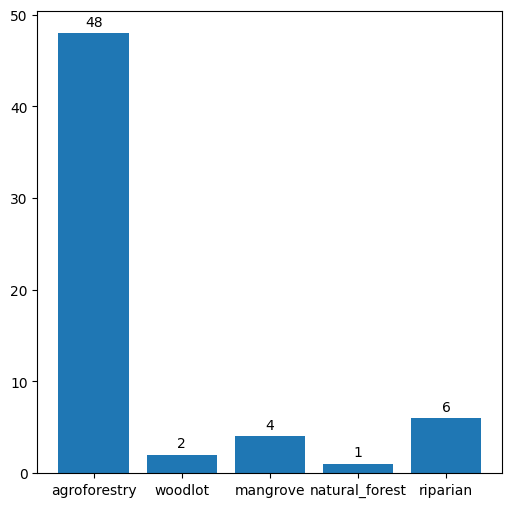

In [17]:
fig, ax = plt.subplots(figsize=(6,6))

counts = [ft[col].sum() for col in land_use]
plt.bar(land_use, counts)

for bars in ax.containers:
    ax.bar_label(bars,
                 label_type='edge', padding=3);

In [18]:
no_landuse = []
for index, row in ft.iterrows():
    if row[land_use].sum() == 0:
        no_landuse.append(row['project'])

In [20]:
print(len(no_landuse))

25


In [80]:
ft[ft.project == 'ncf']

,project,area_ha,percent_imagery_coverage,agroforestry,tree_planting,assisted_natural_regeneration,enrichment_planting,reforestation,direct_propagules_planting,natural_regeneration,applied_nucleation/tree_island,woodlot,direct_seeding,mangrove,natural_forest,riparian
68,ncf,256.97044,100.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
ttc[ttc.project == 'ncf']

,ttc,project,sitename,areaha,plantstart,target_sys,canopy
11,14.0,ncf,Abuja Conservation Centre,210.471939,2023-08-01 00:00:00,Null,open
76,9.0,ncf,"Ajingi, Kano",28.963651,2023-01-20 00:00:00,Null,open
4361,15.0,ncf,"Nnamdi Azikiwe University, Awka, Anambra",10.064798,2022-08-01 00:00:00,Null,open


In [ ]:
# imagery
# what does % represent?
# what threshold is usable vs not?